# Input 32 Output 32

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py


from tensorflow.keras.layers import MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 
from sklearn.model_selection import KFold

In [2]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

# spatial slicing dimensions
os = 32 # output slice size
halo = 0 # edge cells
ts = os + halo * 2 # total input slice:31 size including halos 
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 128 # number of slices in one profile 



In [3]:
print("train_size:",train_size)
print("test_size:",test_size)

train_size: 3200
test_size: 800


In [4]:
# spatial slicing the profiles

image=np.zeros((l2r*num,ts,nchan)) 
label=np.zeros((l2r*num,os)) 

for i in range(num):
    for a in range(l2r):
#cut each profile into 128 slices. 
#label: tau channel 
#1profile ..2profile...3 profile

        img= data[i, a*os:a*os+ts, 0:nchan] #input: 32 pixels for one slice, 3 channels 
        lb = data[i, a*os:a*os+os, nchan] #32 pixels for label,the tau channel is the label
        image[i*l2r+a]=img
        label[i*l2r+a]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) 


whole dataset features size:  (512000, 32, 3) whole dataset label size:  (512000, 32)


In [5]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [6]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()

bsize = 1024
eps = 2000

#bi-LSTM
input_layer = tf.keras.layers.Input(shape=(ts,nchan),name='Input')
bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True,input_shape=(ts,nchan)))(input_layer) #kernel size 6, 100 filters for each 3 channel
bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(bi) #kernel size 6, 100 filters for each 3 input_layerchannel

#transformer block
slf_attn = MultiHeadAttention(num_heads=3,key_dim=64)(bi,bi)
add1=tf.keras.layers.Add()([slf_attn,bi])
layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add1)
dense1=tf.keras.layers.Dense(256,activation='relu')(layernorm1)
add2=tf.keras.layers.Add()([layernorm1,dense1])
layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add2)

#pooling
avg_pool = GlobalAveragePooling1D()(layernorm2)
max_pool = GlobalMaxPooling1D()(layernorm2)
conc = concatenate([avg_pool, max_pool])

#output layers
dense2 = tf.keras.layers.Dense(128,activation='relu')(conc)
output = tf.keras.layers.Dense(os,activation='relu')(dense2)

model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 32, 256)      135168      Input[0][0]                      
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32, 256)      394240      bidirectional[0][0]              
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 32, 256)      197440      bidirectional_1[0][0]            
                                                                 bidirectional_1[0][0]        

In [7]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [8]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()

bsize = 1024
eps = 2000

def eval_model(train_image, test_image, train_label, test_label):

    #bi-LSTM
    input_layer = tf.keras.layers.Input(shape=(ts,nchan),name='Input')
    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True,input_shape=(ts,nchan)))(input_layer) #kernel size 6, 100 filters for each 3 channel
    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(bi) #kernel size 6, 100 filters for each 3 input_layerchannel

    #transformer block
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=64)(bi,bi)
    add1=tf.keras.layers.Add()([slf_attn,bi])
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add1)
    dense1=tf.keras.layers.Dense(256,activation='relu')(layernorm1)
    add2=tf.keras.layers.Add()([layernorm1,dense1])
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add2)

    #pooling
    avg_pool = GlobalAveragePooling1D()(layernorm2)
    max_pool = GlobalMaxPooling1D()(layernorm2)
    conc = concatenate([avg_pool, max_pool])

    #output layers
    dense2 = tf.keras.layers.Dense(128,activation='relu')(conc)
    output = tf.keras.layers.Dense(os,activation='relu')(dense2)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])
    model.summary()
    
    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions

In [9]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(image))
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),ts,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts,3))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [102400 102401 102402 ... 511997 511998 511999] TEST: [     0      1      2 ... 102397 102398 102399]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [102400 102401 102402 ... 204797 204798 204799]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [204800 204801 204802 ... 307197 307198 307199]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [307200 307201 307202 ... 409597 409598 409599]
TRAIN: [     0      1      2 ... 409597 409598 409599] TEST: [409600 409601 409602 ... 511997 511998 511999]


In [10]:
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 32, 256)      135168      Input[0][0]                      
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 32, 256)      394240      bidirectional_2[0][0]            
__________________________________________________________________________________________________
multi_head_attention_1 (MultiHe (None, 32, 256)      197440      bidirectional_3[0][0]            
                                                                 bidirectional_3[0][0]      

Epoch 20/2000
350/350 [==============================] - 20s 57ms/step - loss: 6.7109 - mean_squared_error: 6.7109 - root_mean_squared_error: 2.5903 - val_loss: 6.4470 - val_mean_squared_error: 6.4470 - val_root_mean_squared_error: 2.5391
Epoch 21/2000
350/350 [==============================] - 20s 57ms/step - loss: 6.4451 - mean_squared_error: 6.4451 - root_mean_squared_error: 2.5381 - val_loss: 6.2270 - val_mean_squared_error: 6.2270 - val_root_mean_squared_error: 2.4954
Epoch 22/2000
350/350 [==============================] - 20s 57ms/step - loss: 6.3015 - mean_squared_error: 6.3015 - root_mean_squared_error: 2.5102 - val_loss: 5.3716 - val_mean_squared_error: 5.3716 - val_root_mean_squared_error: 2.3177
Epoch 23/2000
350/350 [==============================] - 20s 57ms/step - loss: 5.6651 - mean_squared_error: 5.6651 - root_mean_squared_error: 2.3798 - val_loss: 5.4090 - val_mean_squared_error: 5.4090 - val_root_mean_squared_error: 2.3257
Epoch 24/2000
350/350 [=====================

350/350 [==============================] - 20s 57ms/step - loss: 1.0296 - mean_squared_error: 1.0296 - root_mean_squared_error: 1.0145 - val_loss: 2.4280 - val_mean_squared_error: 2.4280 - val_root_mean_squared_error: 1.5582
Epoch 89/2000
350/350 [==============================] - 20s 57ms/step - loss: 1.4164 - mean_squared_error: 1.4164 - root_mean_squared_error: 1.1873 - val_loss: 1.7004 - val_mean_squared_error: 1.7004 - val_root_mean_squared_error: 1.3040
Epoch 90/2000
350/350 [==============================] - 20s 57ms/step - loss: 1.2784 - mean_squared_error: 1.2784 - root_mean_squared_error: 1.1305 - val_loss: 1.6305 - val_mean_squared_error: 1.6305 - val_root_mean_squared_error: 1.2769
Epoch 91/2000
350/350 [==============================] - 20s 57ms/step - loss: 1.0039 - mean_squared_error: 1.0039 - root_mean_squared_error: 1.0019 - val_loss: 1.7607 - val_mean_squared_error: 1.7607 - val_root_mean_squared_error: 1.3269
Epoch 92/2000
350/350 [==============================] - 2

350/350 [==============================] - 20s 57ms/step - loss: 1.2971 - mean_squared_error: 1.2971 - root_mean_squared_error: 1.1328 - val_loss: 1.2110 - val_mean_squared_error: 1.2110 - val_root_mean_squared_error: 1.1004
Epoch 157/2000
350/350 [==============================] - 20s 57ms/step - loss: 0.5667 - mean_squared_error: 0.5667 - root_mean_squared_error: 0.7527 - val_loss: 1.1012 - val_mean_squared_error: 1.1012 - val_root_mean_squared_error: 1.0494
Epoch 158/2000
350/350 [==============================] - 20s 57ms/step - loss: 0.4689 - mean_squared_error: 0.4689 - root_mean_squared_error: 0.6847 - val_loss: 1.1914 - val_mean_squared_error: 1.1914 - val_root_mean_squared_error: 1.0915
Epoch 159/2000
350/350 [==============================] - 20s 57ms/step - loss: 0.4380 - mean_squared_error: 0.4380 - root_mean_squared_error: 0.6618 - val_loss: 1.0324 - val_mean_squared_error: 1.0324 - val_root_mean_squared_error: 1.0161
Epoch 160/2000
350/350 [==============================]

350/350 [==============================] - 20s 57ms/step - loss: 0.3440 - mean_squared_error: 0.3440 - root_mean_squared_error: 0.5864 - val_loss: 0.8641 - val_mean_squared_error: 0.8641 - val_root_mean_squared_error: 0.9296
Epoch 225/2000
350/350 [==============================] - 20s 57ms/step - loss: 0.3699 - mean_squared_error: 0.3699 - root_mean_squared_error: 0.6082 - val_loss: 0.9235 - val_mean_squared_error: 0.9235 - val_root_mean_squared_error: 0.9610
Epoch 226/2000
350/350 [==============================] - 20s 57ms/step - loss: 0.3629 - mean_squared_error: 0.3629 - root_mean_squared_error: 0.6024 - val_loss: 0.9241 - val_mean_squared_error: 0.9241 - val_root_mean_squared_error: 0.9613
Epoch 227/2000
350/350 [==============================] - 20s 57ms/step - loss: 0.7491 - mean_squared_error: 0.7491 - root_mean_squared_error: 0.8559 - val_loss: 1.5544 - val_mean_squared_error: 1.5544 - val_root_mean_squared_error: 1.2467
Epoch 228/2000
350/350 [==============================]

350/350 [==============================] - 27s 61ms/step - loss: 37.6591 - mean_squared_error: 37.6591 - root_mean_squared_error: 4.3726 - val_loss: 17.9744 - val_mean_squared_error: 17.9744 - val_root_mean_squared_error: 4.2396
Epoch 2/2000
350/350 [==============================] - 20s 57ms/step - loss: 21.2012 - mean_squared_error: 21.2012 - root_mean_squared_error: 4.6039 - val_loss: 16.7787 - val_mean_squared_error: 16.7787 - val_root_mean_squared_error: 4.0962
Epoch 3/2000
350/350 [==============================] - 20s 57ms/step - loss: 19.5333 - mean_squared_error: 19.5333 - root_mean_squared_error: 4.4195 - val_loss: 16.3727 - val_mean_squared_error: 16.3727 - val_root_mean_squared_error: 4.0463
Epoch 4/2000
350/350 [==============================] - 20s 57ms/step - loss: 17.9721 - mean_squared_error: 17.9721 - root_mean_squared_error: 4.2392 - val_loss: 17.4866 - val_mean_squared_error: 17.4866 - val_root_mean_squared_error: 4.1817
Epoch 5/2000
350/350 [=======================

350/350 [==============================] - 21s 59ms/step - loss: 1.4377 - mean_squared_error: 1.4377 - root_mean_squared_error: 1.1988 - val_loss: 2.2393 - val_mean_squared_error: 2.2393 - val_root_mean_squared_error: 1.4964
Epoch 70/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.7009 - mean_squared_error: 1.7009 - root_mean_squared_error: 1.3038 - val_loss: 3.2147 - val_mean_squared_error: 3.2147 - val_root_mean_squared_error: 1.7930
Epoch 71/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.7634 - mean_squared_error: 1.7634 - root_mean_squared_error: 1.3261 - val_loss: 1.9031 - val_mean_squared_error: 1.9031 - val_root_mean_squared_error: 1.3795
Epoch 72/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.3397 - mean_squared_error: 1.3397 - root_mean_squared_error: 1.1571 - val_loss: 2.1274 - val_mean_squared_error: 2.1274 - val_root_mean_squared_error: 1.4586
Epoch 73/2000
350/350 [==============================] - 2

350/350 [==============================] - 21s 59ms/step - loss: 0.9644 - mean_squared_error: 0.9644 - root_mean_squared_error: 0.9700 - val_loss: 1.5651 - val_mean_squared_error: 1.5651 - val_root_mean_squared_error: 1.2510
Epoch 138/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.1622 - mean_squared_error: 1.1622 - root_mean_squared_error: 1.0756 - val_loss: 1.3230 - val_mean_squared_error: 1.3230 - val_root_mean_squared_error: 1.1502
Epoch 139/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.5673 - mean_squared_error: 0.5673 - root_mean_squared_error: 0.7531 - val_loss: 1.1910 - val_mean_squared_error: 1.1910 - val_root_mean_squared_error: 1.0913
Epoch 140/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.5035 - mean_squared_error: 0.5035 - root_mean_squared_error: 0.7095 - val_loss: 1.1542 - val_mean_squared_error: 1.1542 - val_root_mean_squared_error: 1.0743
Epoch 141/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.3253 - mean_squared_error: 0.3253 - root_mean_squared_error: 0.5703 - val_loss: 0.9735 - val_mean_squared_error: 0.9735 - val_root_mean_squared_error: 0.9867
Epoch 206/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3362 - mean_squared_error: 0.3362 - root_mean_squared_error: 0.5798 - val_loss: 0.9272 - val_mean_squared_error: 0.9272 - val_root_mean_squared_error: 0.9629
Epoch 207/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3431 - mean_squared_error: 0.3431 - root_mean_squared_error: 0.5856 - val_loss: 1.0110 - val_mean_squared_error: 1.0110 - val_root_mean_squared_error: 1.0055
Epoch 208/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4164 - mean_squared_error: 0.4164 - root_mean_squared_error: 0.6452 - val_loss: 1.1061 - val_mean_squared_error: 1.1061 - val_root_mean_squared_error: 1.0517
Epoch 209/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.2876 - mean_squared_error: 0.2876 - root_mean_squared_error: 0.5360 - val_loss: 1.0453 - val_mean_squared_error: 1.0453 - val_root_mean_squared_error: 1.0224
Epoch 274/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.0591 - mean_squared_error: 1.0591 - root_mean_squared_error: 1.0249 - val_loss: 1.0284 - val_mean_squared_error: 1.0284 - val_root_mean_squared_error: 1.0141
Epoch 275/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4388 - mean_squared_error: 0.4388 - root_mean_squared_error: 0.6610 - val_loss: 0.8245 - val_mean_squared_error: 0.8245 - val_root_mean_squared_error: 0.9080
Epoch 276/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.2610 - mean_squared_error: 0.2610 - root_mean_squared_error: 0.5109 - val_loss: 0.8553 - val_mean_squared_error: 0.8553 - val_root_mean_squared_error: 0.9248
Epoch 277/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.1668 - mean_squared_error: 0.1668 - root_mean_squared_error: 0.4084 - val_loss: 0.7366 - val_mean_squared_error: 0.7366 - val_root_mean_squared_error: 0.8583
Epoch 342/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1513 - mean_squared_error: 0.1513 - root_mean_squared_error: 0.3890 - val_loss: 0.7319 - val_mean_squared_error: 0.7319 - val_root_mean_squared_error: 0.8555
Epoch 343/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1417 - mean_squared_error: 0.1417 - root_mean_squared_error: 0.3764 - val_loss: 0.7222 - val_mean_squared_error: 0.7222 - val_root_mean_squared_error: 0.8498
Epoch 344/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1468 - mean_squared_error: 0.1468 - root_mean_squared_error: 0.3832 - val_loss: 0.7510 - val_mean_squared_error: 0.7510 - val_root_mean_squared_error: 0.8666
Epoch 345/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.1571 - mean_squared_error: 0.1571 - root_mean_squared_error: 0.3960 - val_loss: 0.7231 - val_mean_squared_error: 0.7231 - val_root_mean_squared_error: 0.8504
Epoch 410/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1512 - mean_squared_error: 0.1512 - root_mean_squared_error: 0.3889 - val_loss: 0.7077 - val_mean_squared_error: 0.7077 - val_root_mean_squared_error: 0.8412
Epoch 411/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1431 - mean_squared_error: 0.1431 - root_mean_squared_error: 0.3783 - val_loss: 0.7473 - val_mean_squared_error: 0.7473 - val_root_mean_squared_error: 0.8645
Epoch 412/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1513 - mean_squared_error: 0.1513 - root_mean_squared_error: 0.3890 - val_loss: 0.7287 - val_mean_squared_error: 0.7287 - val_root_mean_squared_error: 0.8537
Epoch 413/2000
350/350 [==============================]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 32, 256)      135168      Input[0][0]                      
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 32, 256)      394240      bidirectional_6[0][0]            
__________________________________________________________________________________________________
multi_head_attention_3 (MultiHe (None, 32, 256)      197440      bidirectional_7[0][0]            
                                                                 bidirectional_7[0][0]      

Epoch 20/2000
350/350 [==============================] - 21s 59ms/step - loss: 8.9778 - mean_squared_error: 8.9778 - root_mean_squared_error: 2.9962 - val_loss: 7.7565 - val_mean_squared_error: 7.7565 - val_root_mean_squared_error: 2.7850
Epoch 21/2000
350/350 [==============================] - 20s 59ms/step - loss: 8.3202 - mean_squared_error: 8.3202 - root_mean_squared_error: 2.8840 - val_loss: 7.7572 - val_mean_squared_error: 7.7572 - val_root_mean_squared_error: 2.7852
Epoch 22/2000
350/350 [==============================] - 21s 59ms/step - loss: 7.9226 - mean_squared_error: 7.9226 - root_mean_squared_error: 2.8130 - val_loss: 7.4889 - val_mean_squared_error: 7.4889 - val_root_mean_squared_error: 2.7366
Epoch 23/2000
350/350 [==============================] - 21s 59ms/step - loss: 7.5527 - mean_squared_error: 7.5527 - root_mean_squared_error: 2.7477 - val_loss: 6.2777 - val_mean_squared_error: 6.2777 - val_root_mean_squared_error: 2.5055
Epoch 24/2000
350/350 [=====================

350/350 [==============================] - 21s 59ms/step - loss: 2.2947 - mean_squared_error: 2.2947 - root_mean_squared_error: 1.5052 - val_loss: 2.0267 - val_mean_squared_error: 2.0267 - val_root_mean_squared_error: 1.4236
Epoch 89/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.2215 - mean_squared_error: 1.2215 - root_mean_squared_error: 1.1047 - val_loss: 1.8155 - val_mean_squared_error: 1.8155 - val_root_mean_squared_error: 1.3474
Epoch 90/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.9968 - mean_squared_error: 0.9968 - root_mean_squared_error: 0.9984 - val_loss: 1.5247 - val_mean_squared_error: 1.5247 - val_root_mean_squared_error: 1.2348
Epoch 91/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.9593 - mean_squared_error: 0.9593 - root_mean_squared_error: 0.9792 - val_loss: 1.3853 - val_mean_squared_error: 1.3853 - val_root_mean_squared_error: 1.1770
Epoch 92/2000
350/350 [==============================] - 2

350/350 [==============================] - 21s 59ms/step - loss: 0.4754 - mean_squared_error: 0.4754 - root_mean_squared_error: 0.6894 - val_loss: 1.1859 - val_mean_squared_error: 1.1859 - val_root_mean_squared_error: 1.0890
Epoch 157/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4778 - mean_squared_error: 0.4778 - root_mean_squared_error: 0.6912 - val_loss: 1.0812 - val_mean_squared_error: 1.0812 - val_root_mean_squared_error: 1.0398
Epoch 158/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4591 - mean_squared_error: 0.4591 - root_mean_squared_error: 0.6775 - val_loss: 1.1193 - val_mean_squared_error: 1.1193 - val_root_mean_squared_error: 1.0579
Epoch 159/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.5391 - mean_squared_error: 1.5391 - root_mean_squared_error: 1.2232 - val_loss: 1.4259 - val_mean_squared_error: 1.4259 - val_root_mean_squared_error: 1.1941
Epoch 160/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.2876 - mean_squared_error: 0.2876 - root_mean_squared_error: 0.5363 - val_loss: 0.9181 - val_mean_squared_error: 0.9181 - val_root_mean_squared_error: 0.9582
Epoch 225/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.2974 - mean_squared_error: 0.2974 - root_mean_squared_error: 0.5454 - val_loss: 0.9023 - val_mean_squared_error: 0.9023 - val_root_mean_squared_error: 0.9499
Epoch 226/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3047 - mean_squared_error: 0.3047 - root_mean_squared_error: 0.5519 - val_loss: 1.0213 - val_mean_squared_error: 1.0213 - val_root_mean_squared_error: 1.0106
Epoch 227/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3490 - mean_squared_error: 0.3490 - root_mean_squared_error: 0.5906 - val_loss: 0.9058 - val_mean_squared_error: 0.9058 - val_root_mean_squared_error: 0.9517
Epoch 228/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.2653 - mean_squared_error: 0.2653 - root_mean_squared_error: 0.5151 - val_loss: 0.9567 - val_mean_squared_error: 0.9567 - val_root_mean_squared_error: 0.9781
Epoch 293/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.2498 - mean_squared_error: 0.2498 - root_mean_squared_error: 0.4998 - val_loss: 0.8726 - val_mean_squared_error: 0.8726 - val_root_mean_squared_error: 0.9341
Epoch 294/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.2844 - mean_squared_error: 0.2844 - root_mean_squared_error: 0.5332 - val_loss: 0.8700 - val_mean_squared_error: 0.8700 - val_root_mean_squared_error: 0.9328
Epoch 295/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3135 - mean_squared_error: 0.3135 - root_mean_squared_error: 0.5573 - val_loss: 0.9307 - val_mean_squared_error: 0.9307 - val_root_mean_squared_error: 0.9647
Epoch 296/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 2.6665 - mean_squared_error: 2.6665 - root_mean_squared_error: 1.6325 - val_loss: 2.9912 - val_mean_squared_error: 2.9912 - val_root_mean_squared_error: 1.7295
Epoch 46/2000
350/350 [==============================] - 21s 59ms/step - loss: 2.6002 - mean_squared_error: 2.6002 - root_mean_squared_error: 1.6120 - val_loss: 3.1229 - val_mean_squared_error: 3.1229 - val_root_mean_squared_error: 1.7672
Epoch 47/2000
350/350 [==============================] - 21s 59ms/step - loss: 2.4527 - mean_squared_error: 2.4527 - root_mean_squared_error: 1.5657 - val_loss: 3.1547 - val_mean_squared_error: 3.1547 - val_root_mean_squared_error: 1.7761
Epoch 48/2000
350/350 [==============================] - 21s 59ms/step - loss: 2.3389 - mean_squared_error: 2.3389 - root_mean_squared_error: 1.5292 - val_loss: 2.5526 - val_mean_squared_error: 2.5526 - val_root_mean_squared_error: 1.5977
Epoch 49/2000
350/350 [==============================] - 2

350/350 [==============================] - 21s 59ms/step - loss: 0.7918 - mean_squared_error: 0.7918 - root_mean_squared_error: 0.8898 - val_loss: 1.3377 - val_mean_squared_error: 1.3377 - val_root_mean_squared_error: 1.1566
Epoch 114/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.7298 - mean_squared_error: 0.7298 - root_mean_squared_error: 0.8541 - val_loss: 1.2873 - val_mean_squared_error: 1.2873 - val_root_mean_squared_error: 1.1346
Epoch 115/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.8188 - mean_squared_error: 0.8188 - root_mean_squared_error: 0.9031 - val_loss: 1.4750 - val_mean_squared_error: 1.4750 - val_root_mean_squared_error: 1.2145
Epoch 116/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.8490 - mean_squared_error: 0.8490 - root_mean_squared_error: 0.9213 - val_loss: 1.4855 - val_mean_squared_error: 1.4855 - val_root_mean_squared_error: 1.2188
Epoch 117/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.5020 - mean_squared_error: 0.5020 - root_mean_squared_error: 0.7084 - val_loss: 1.1010 - val_mean_squared_error: 1.1010 - val_root_mean_squared_error: 1.0493
Epoch 182/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4311 - mean_squared_error: 0.4311 - root_mean_squared_error: 0.6565 - val_loss: 1.0726 - val_mean_squared_error: 1.0726 - val_root_mean_squared_error: 1.0357
Epoch 183/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4052 - mean_squared_error: 0.4052 - root_mean_squared_error: 0.6365 - val_loss: 1.0003 - val_mean_squared_error: 1.0003 - val_root_mean_squared_error: 1.0001
Epoch 184/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4029 - mean_squared_error: 0.4029 - root_mean_squared_error: 0.6347 - val_loss: 1.0552 - val_mean_squared_error: 1.0552 - val_root_mean_squared_error: 1.0272
Epoch 185/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.2996 - mean_squared_error: 0.2996 - root_mean_squared_error: 0.5473 - val_loss: 0.9654 - val_mean_squared_error: 0.9654 - val_root_mean_squared_error: 0.9826
Epoch 250/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3013 - mean_squared_error: 0.3013 - root_mean_squared_error: 0.5489 - val_loss: 0.9514 - val_mean_squared_error: 0.9514 - val_root_mean_squared_error: 0.9754
Epoch 251/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3173 - mean_squared_error: 0.3173 - root_mean_squared_error: 0.5633 - val_loss: 0.8645 - val_mean_squared_error: 0.8645 - val_root_mean_squared_error: 0.9298
Epoch 252/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.6021 - mean_squared_error: 0.6021 - root_mean_squared_error: 0.7433 - val_loss: 1.4106 - val_mean_squared_error: 1.4106 - val_root_mean_squared_error: 1.1877
Epoch 253/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.2514 - mean_squared_error: 0.2514 - root_mean_squared_error: 0.5014 - val_loss: 0.8539 - val_mean_squared_error: 0.8539 - val_root_mean_squared_error: 0.9240
Epoch 318/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.2389 - mean_squared_error: 0.2389 - root_mean_squared_error: 0.4887 - val_loss: 0.9081 - val_mean_squared_error: 0.9081 - val_root_mean_squared_error: 0.9529
Epoch 319/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.2658 - mean_squared_error: 0.2658 - root_mean_squared_error: 0.5152 - val_loss: 0.8231 - val_mean_squared_error: 0.8231 - val_root_mean_squared_error: 0.9073
Epoch 320/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.2514 - mean_squared_error: 0.2514 - root_mean_squared_error: 0.5014 - val_loss: 0.8520 - val_mean_squared_error: 0.8520 - val_root_mean_squared_error: 0.9230
Epoch 321/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 10.8400 - mean_squared_error: 10.8400 - root_mean_squared_error: 3.2917 - val_loss: 11.7038 - val_mean_squared_error: 11.7038 - val_root_mean_squared_error: 3.4211
Epoch 15/2000
350/350 [==============================] - 21s 59ms/step - loss: 10.2165 - mean_squared_error: 10.2165 - root_mean_squared_error: 3.1960 - val_loss: 10.3396 - val_mean_squared_error: 10.3396 - val_root_mean_squared_error: 3.2155
Epoch 16/2000
350/350 [==============================] - 21s 59ms/step - loss: 10.0617 - mean_squared_error: 10.0617 - root_mean_squared_error: 3.1713 - val_loss: 9.4576 - val_mean_squared_error: 9.4576 - val_root_mean_squared_error: 3.0753
Epoch 17/2000
350/350 [==============================] - 21s 59ms/step - loss: 9.6670 - mean_squared_error: 9.6670 - root_mean_squared_error: 3.1079 - val_loss: 9.7041 - val_mean_squared_error: 9.7041 - val_root_mean_squared_error: 3.1151
Epoch 18/2000
350/350 [=========================

350/350 [==============================] - 21s 59ms/step - loss: 1.1238 - mean_squared_error: 1.1238 - root_mean_squared_error: 1.0600 - val_loss: 2.0606 - val_mean_squared_error: 2.0606 - val_root_mean_squared_error: 1.4355
Epoch 83/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.1868 - mean_squared_error: 1.1868 - root_mean_squared_error: 1.0893 - val_loss: 1.7057 - val_mean_squared_error: 1.7057 - val_root_mean_squared_error: 1.3060
Epoch 84/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.2678 - mean_squared_error: 1.2678 - root_mean_squared_error: 1.1256 - val_loss: 2.0296 - val_mean_squared_error: 2.0296 - val_root_mean_squared_error: 1.4246
Epoch 85/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.2069 - mean_squared_error: 1.2069 - root_mean_squared_error: 1.0983 - val_loss: 1.8940 - val_mean_squared_error: 1.8940 - val_root_mean_squared_error: 1.3762
Epoch 86/2000
350/350 [==============================] - 2

350/350 [==============================] - 21s 59ms/step - loss: 0.9544 - mean_squared_error: 0.9544 - root_mean_squared_error: 0.9762 - val_loss: 1.0777 - val_mean_squared_error: 1.0777 - val_root_mean_squared_error: 1.0381
Epoch 151/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.5422 - mean_squared_error: 0.5422 - root_mean_squared_error: 0.7362 - val_loss: 1.0301 - val_mean_squared_error: 1.0301 - val_root_mean_squared_error: 1.0149
Epoch 152/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4590 - mean_squared_error: 0.4590 - root_mean_squared_error: 0.6775 - val_loss: 0.9942 - val_mean_squared_error: 0.9942 - val_root_mean_squared_error: 0.9971
Epoch 153/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.4325 - mean_squared_error: 0.4325 - root_mean_squared_error: 0.6576 - val_loss: 0.9905 - val_mean_squared_error: 0.9905 - val_root_mean_squared_error: 0.9953
Epoch 154/2000
350/350 [==============================]

350/350 [==============================] - 20s 59ms/step - loss: 0.2949 - mean_squared_error: 0.2949 - root_mean_squared_error: 0.5430 - val_loss: 0.9194 - val_mean_squared_error: 0.9194 - val_root_mean_squared_error: 0.9588
Epoch 219/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3131 - mean_squared_error: 0.3131 - root_mean_squared_error: 0.5595 - val_loss: 0.8684 - val_mean_squared_error: 0.8684 - val_root_mean_squared_error: 0.9319
Epoch 220/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3363 - mean_squared_error: 0.3363 - root_mean_squared_error: 0.5799 - val_loss: 0.8478 - val_mean_squared_error: 0.8478 - val_root_mean_squared_error: 0.9208
Epoch 221/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3315 - mean_squared_error: 0.3315 - root_mean_squared_error: 0.5757 - val_loss: 0.8435 - val_mean_squared_error: 0.8435 - val_root_mean_squared_error: 0.9184
Epoch 222/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.2222 - mean_squared_error: 0.2222 - root_mean_squared_error: 0.4714 - val_loss: 0.7074 - val_mean_squared_error: 0.7074 - val_root_mean_squared_error: 0.8411
Epoch 287/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.2765 - mean_squared_error: 0.2765 - root_mean_squared_error: 0.5210 - val_loss: 1.6303 - val_mean_squared_error: 1.6303 - val_root_mean_squared_error: 1.2768
Epoch 288/2000
350/350 [==============================] - 21s 59ms/step - loss: 1.2880 - mean_squared_error: 1.2880 - root_mean_squared_error: 1.1295 - val_loss: 1.1573 - val_mean_squared_error: 1.1573 - val_root_mean_squared_error: 1.0758
Epoch 289/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.3723 - mean_squared_error: 0.3723 - root_mean_squared_error: 0.6068 - val_loss: 0.7067 - val_mean_squared_error: 0.7067 - val_root_mean_squared_error: 0.8407
Epoch 290/2000
350/350 [==============================]

350/350 [==============================] - 21s 59ms/step - loss: 0.1139 - mean_squared_error: 0.1139 - root_mean_squared_error: 0.3374 - val_loss: 0.5981 - val_mean_squared_error: 0.5981 - val_root_mean_squared_error: 0.7734
Epoch 355/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - root_mean_squared_error: 0.3244 - val_loss: 0.5999 - val_mean_squared_error: 0.5999 - val_root_mean_squared_error: 0.7745
Epoch 356/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1000 - mean_squared_error: 0.1000 - root_mean_squared_error: 0.3163 - val_loss: 0.6021 - val_mean_squared_error: 0.6021 - val_root_mean_squared_error: 0.7759
Epoch 357/2000
350/350 [==============================] - 21s 59ms/step - loss: 0.1042 - mean_squared_error: 0.1042 - root_mean_squared_error: 0.3227 - val_loss: 0.6022 - val_mean_squared_error: 0.6022 - val_root_mean_squared_error: 0.7760
Epoch 358/2000
350/350 [==============================]

In [11]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 0.8202 with standard deviation (0.0988)
Estimated RMSE 0.9039 with standard deviation (0.0562)


In [12]:
#quantitative reuslt: mean square error of test set
cv_scores

[0.7970447540283203,
 0.8797051310539246,
 0.9307823181152344,
 0.851067304611206,
 0.6424517631530762]

In [51]:
cv_scores2

[0.8927736282348633,
 0.9379259943962097,
 0.9647706151008606,
 0.9225330948829651,
 0.8015308976173401]

In [52]:
predictions.shape

(102400, 32)

The optimal number of epochs is 346


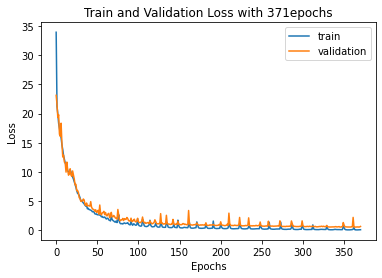

In [53]:
patience=25
# plotting training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [83]:
predict1=np.zeros((4096,))
for i in range((test_size-3)*l2r,(test_size-2)*l2r):
    predict1[(i-(test_size-3)*l2r)*os:(i-(test_size-3)*l2r+1)*os,]=predictions[i]
    
predict2=np.zeros((4096,))
for i in range((test_size-2)*l2r,(test_size-1)*l2r):
    predict2[(i-(test_size-2)*l2r)*os:(i-(test_size-2)*l2r+1)*os,]=predictions[i]
    
predict3=np.zeros((4096,))
for i in range((test_size-1)*l2r,test_size*l2r):
    predict3[(i-(test_size-1)*l2r)*os:(i-(test_size-1)*l2r+1)*os,]=predictions[i]

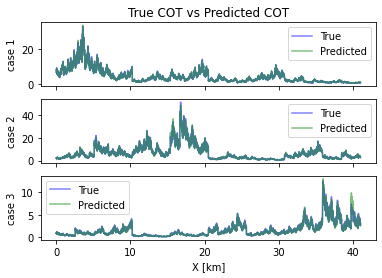

In [84]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+'_3_layers'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"True COT vs Predicted COT")
ax.plot(x[:os*l2r],data[num-3,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict1,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo],data[num-2,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict2.reshape(4096),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo],data[num-1,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict3.reshape(4096),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')




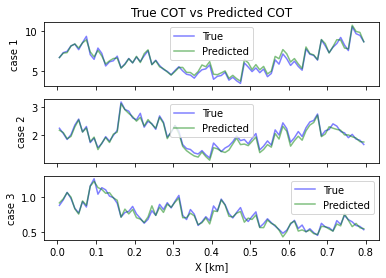

In [87]:
# plotting ----------------------------------------------------------------------------------------------------------------
fgnm = "plots/predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_pixels"+'_3_layers'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"True COT vs Predicted COT")
ax.plot(x[halo:os*l2r+halo][:80],data[num-3,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict1[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo][:80],data[num-2,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict2[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo][:80],data[num-1,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo][:80],predict3[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')